#Fruit Classification with Convolutional Neural Network

In [ ]:
#importing Libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

### Load the Data:

We will use tf.keras.utility to load the image, for this function to work on fruit classification image dataset.

We will do this for both training and validation dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/AI/Fruit Classification/Train"

In [ ]:
# Hyper-parameters:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    
  data_dir,
  validation_split=0.2,
  subset="training",                                
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
    
  )

Found 6277 files belonging to 5 classes.
Using 5022 files for training.


In [ ]:
# Printing out number of Classes
class_names = train_ds.class_names
print(class_names)

['Banana', 'Cherry', 'Grape', 'Mango', 'Peach']


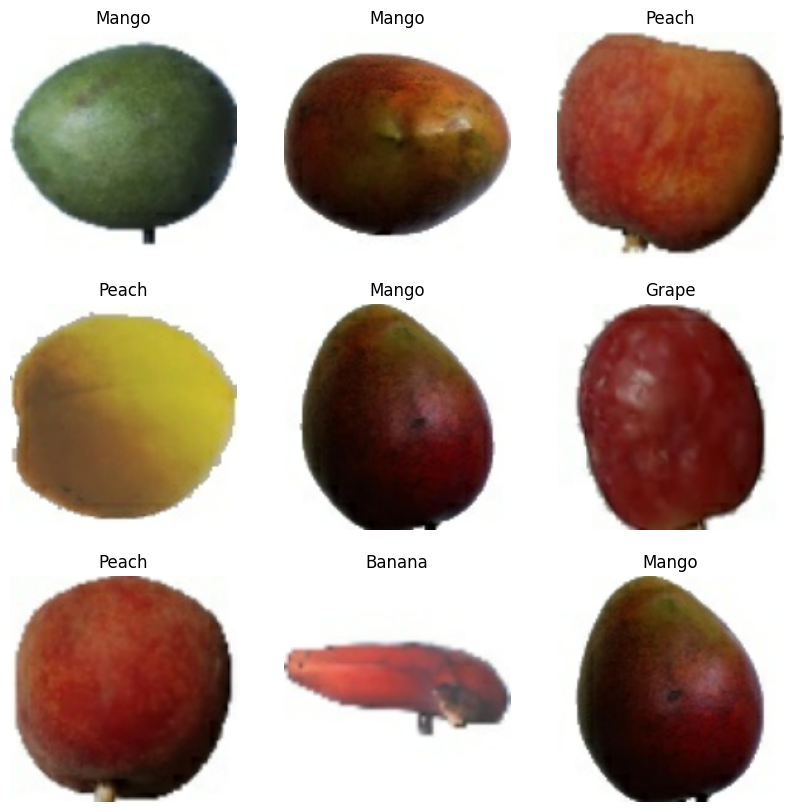

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): #creates touples of image and layer 
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,            #rescales to the [0,1] to normalize pixel values
    shear_range=0.2,           #stretcing specipfic part of image with magnitude 0.2                     ## this is the augmentation configuration we will use for training
    zoom_range=0.3,            #zoom transformation
    horizontal_flip=True,      
    validation_split=0.3,
    fill_mode = 'constant',   #filling pixels with constant
    preprocessing_function=lambda x: np.multiply(x, np.random.normal(loc=1.0, scale=0.1, size=x.shape).astype('float32')) #random noise

    )


# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(180, 180),
    batch_size=batch_size,                      
    class_mode='categorical', #one hot encoded categorical arrays
    subset='training')
# this is a similar generator, for validation data

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(180, 180),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 4397 images belonging to 5 classes.
Found 1880 images belonging to 5 classes.


In [ ]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 5)


In [ ]:
train_generator.num_classes

5

## Design CNN Architecture:




In [ ]:

def generate_model(image_height, image_width, nchannels, num_classes):
  """
  This function will generate a model with set of hyperparameters defined above.
  Input Args:
  image_height[int] = Height of an image.
  image_width[int] = Width of an image.
  nchannels[int] = Number of channels in image.
  num_classes[int] = Number of classes in dataset.
  Output Args:
  model-> A CNN model.
  """
 
  model = tf.keras.Sequential([
      # Rescaling and input layer, [For keras the input shape must be(image height, image width, channels)]
      layers.Rescaling(1./255, input_shape=(image_height,image_width,nchannels)), #bringing into the range of (0,1)
      # First Block of Convolution and Pooling Operations.
      layers.Conv2D(32,(3,3), padding = "same",strides =1,activation='relu'), #padding = same saptial dimesion of output, stride= filter moves 1 pixel at a time
      layers.BatchNormalization(),
      layers.MaxPooling2D(),                                                  #getting the max value within each pooling window
      # Second Block of Convolution and Pooling Operations.
      layers.Conv2D(32,(3,3), padding = "same",strides =1,activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      #third block of convolution and Pooling Operations.
      layers.Conv2D(64,(3,3), padding = "same",strides =1, activation = 'relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),

      # Fourth Block of Convolution and Pooling Operations.
      layers.Conv2D(128,(3,3), padding = "same",strides =1, activation = 'relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),

      # Fully connected classifier.
      layers.Flatten(),                         #multi dimensional output to one dimenional vector
      layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # loss function that penalizes large weights in the layer
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), #lymda = 0.001
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation = "softmax" ), #probabilities of classes 
  ])
  return model

In [ ]:
num_classes = train_generator.num_classes
model = generate_model(img_height, img_width, 3, num_classes)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_114 (Conv2D)         (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_121 (Ba  (None, 180, 180, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_115 (Conv2D)         (None, 90, 90, 32)        9248      
                                                                 
 batch_normalization_122 (Ba  (None, 90, 90, 32)      

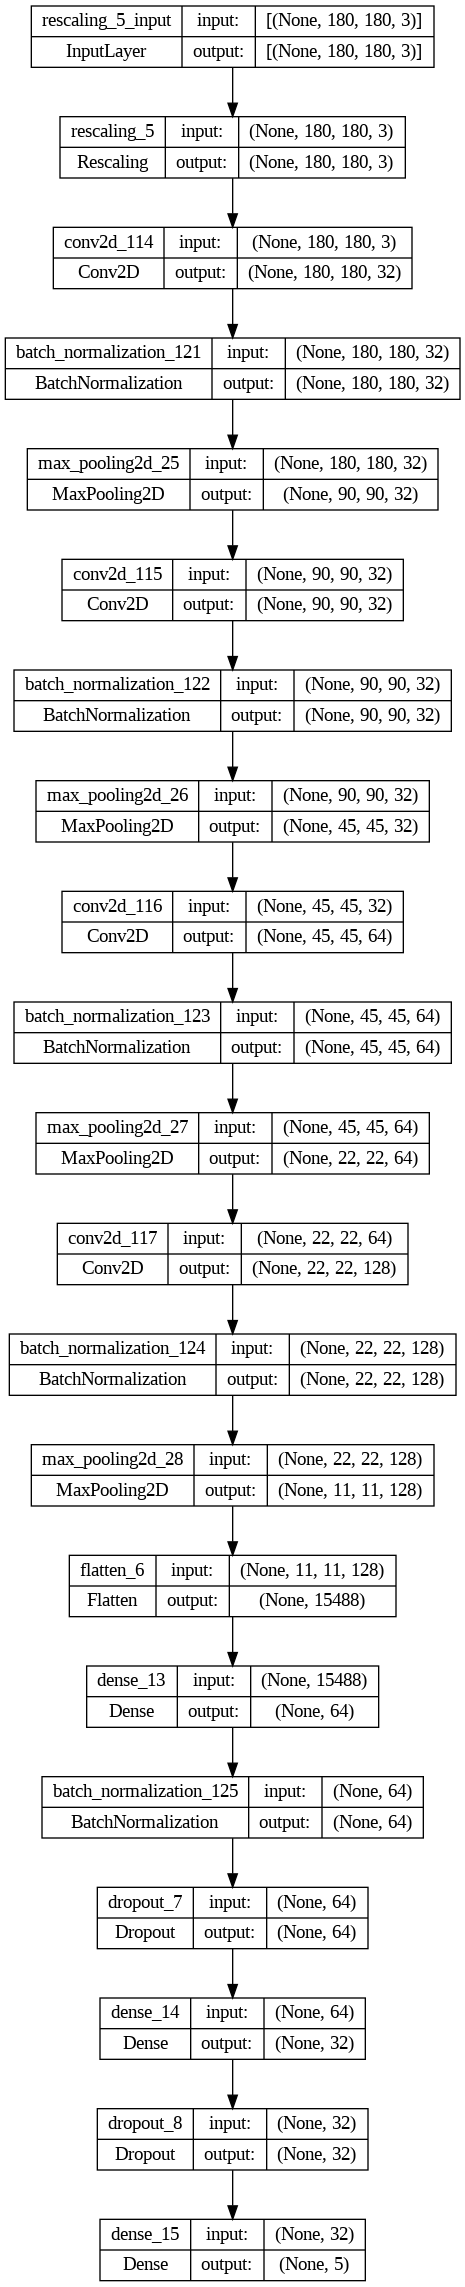

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

## Compile and Train Model.

Once we built the model, we need to compile the model before we start training.

In Model compilation, we do the following:
*   Checks for format Error.
*   Defines the loss function.
*   Defines the optimizer.
*   Defines the learning rate.
*   Defines the metrics we will be using.

For training our model we will be using: 
*   loss --> binary_crossentropy.
*   Optimizer --> rmsorop.
*   Evaluation Metric --> Accuracy.


In [ ]:
model.compile(optimizer='rmsprop',
              loss="binary_crossentropy",
              metrics=['accuracy'])


### Train the Model.

For training a model with all the given hyper-parameters, and argumets we invoke fit methods. 

It is a standard practise to return and hold record of losses values and metric values during training in variablel-history.

In [ ]:
epochs = 6
history = model.fit(
  train_generator,
  validation_data= validation_generator,
  epochs=epochs
)


Epoch 1/6
138/138 [==============================] - 88s 605ms/step - loss: 0.4038 - accuracy: 0.7974 - val_loss: 0.7148 - val_accuracy: 0.2351
Epoch 2/6
138/138 [==============================] - 84s 613ms/step - loss: 0.1736 - accuracy: 0.9509 - val_loss: 1.1366 - val_accuracy: 0.2351
Epoch 3/6
138/138 [==============================] - 85s 614ms/step - loss: 0.1091 - accuracy: 0.9727 - val_loss: 1.3732 - val_accuracy: 0.2351
Epoch 4/6
138/138 [==============================] - 84s 613ms/step - loss: 0.0809 - accuracy: 0.9793 - val_loss: 1.5057 - val_accuracy: 0.3122
Epoch 5/6
138/138 [==============================] - 101s 733ms/step - loss: 0.0703 - accuracy: 0.9798 - val_loss: 0.9953 - val_accuracy: 0.4777
Epoch 6/6
138/138 [==============================] - 84s 613ms/step - loss: 0.0794 - accuracy: 0.9766 - val_loss: 0.9726 - val_accuracy: 0.6271


## Observe the Model Performance.


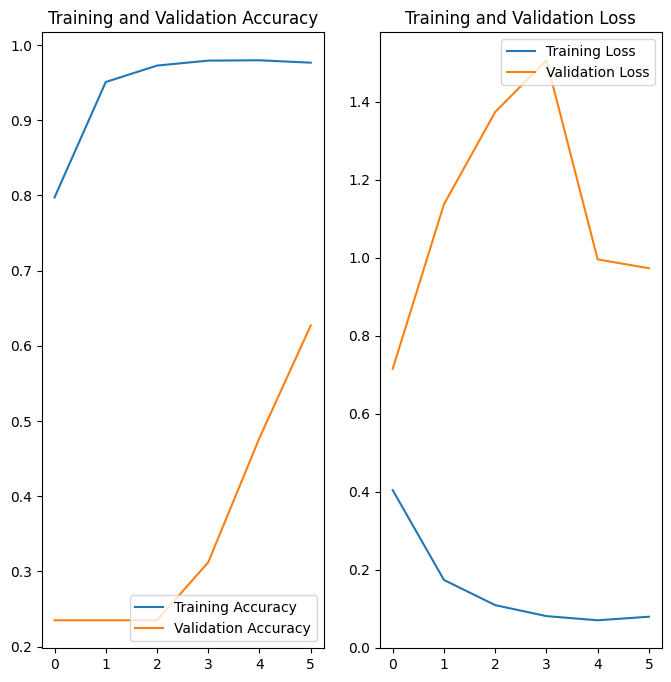

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
from PIL import Image


In [ ]:
def predict_img(img_path):
    img = image.load_img(img_path, target_size=(180, 180))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0

    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    p = model.predict(img[np.newaxis,...])
    print('Confidence: ',str(round(np.max(p[0])*100, 2))+'%')
    print('Class: ',class_names[np.argmax(p[0])])
    


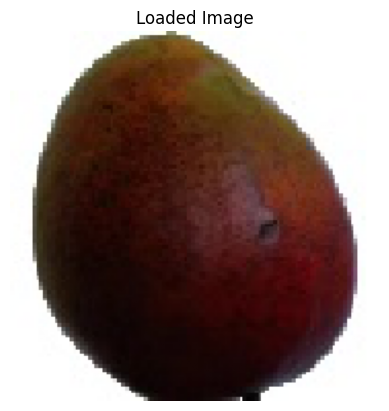

1/1 [==============================] - 0s 156ms/step
Confidence:  99.82%
Class:  Mango


In [ ]:
predict_img('/content/drive/MyDrive/AI/Fruit Classification/Test/11_100.jpg')


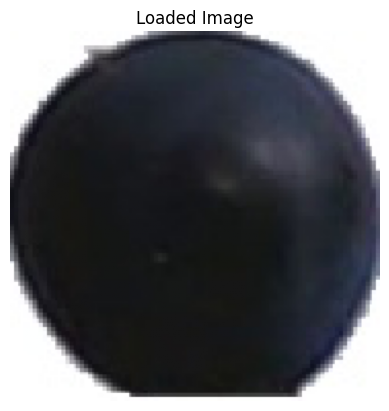

1/1 [==============================] - 0s 21ms/step
Confidence:  100.0%
Class:  Mango


In [ ]:
predict_img('/content/drive/MyDrive/AI/Fruit Classification/Train/Grape/101_100.jpg')


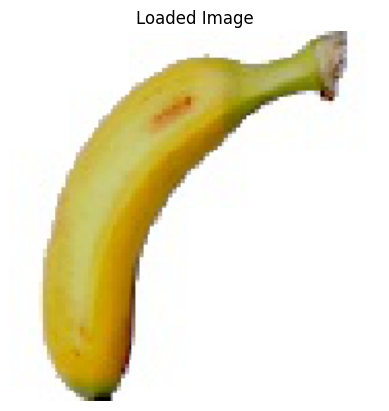

1/1 [==============================] - 0s 21ms/step
Confidence:  99.98%
Class:  Banana


In [ ]:
predict_img('/content/drive/MyDrive/AI/Fruit Classification/Test/1_100(2).jpg')

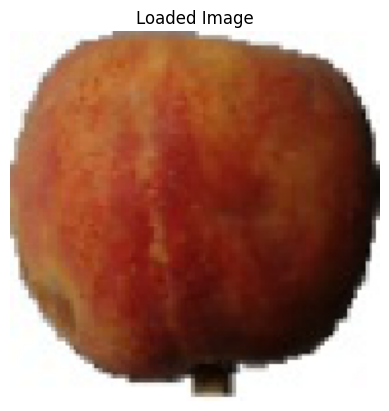

1/1 [==============================] - 0s 22ms/step
Confidence:  100.0%
Class:  Peach


In [ ]:
predict_img('/content/drive/MyDrive/AI/Fruit Classification/Test/26_100.jpg')

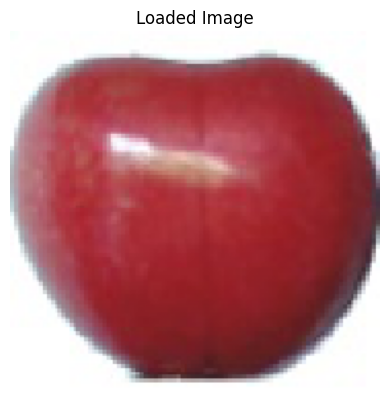

1/1 [==============================] - 0s 31ms/step
Confidence:  100.0%
Class:  Peach


In [ ]:
predict_img('/content/drive/MyDrive/AI/Fruit Classification/Test/5_100.jpg')

#Transfer Learning Inception_V3

In [ ]:
#importing necessory libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, layers

In [ ]:
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False,  input_shape=(180, 180, 3))

Inception V3 Model

In [ ]:
for layer in InceptionV3_model.layers[:-1]:
    layer.trainable = False        #freeze the last layer
    
x = InceptionV3_model.output
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)

output  = layers.Dense(units=5, activation='softmax')(x)
transfer_model = Model(InceptionV3_model.input, output)


transfer_model .summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_118 (Conv2D)            (None, 89, 89, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_126 (Batch  (None, 89, 89, 32)  96          ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                            

Compile The Model

In [ ]:
transfer_model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

Train The Model

In [ ]:
history = transfer_model.fit(train_generator, steps_per_epoch= len(train_generator), epochs = 10, verbose= 1, validation_data = validation_generator, validation_steps = len(train_generator))

Epoch 1/10
138/138 [==============================] - ETA: 0s - loss: 0.2801 - accuracy: 0.9386

138/138 [==============================] - 97s 662ms/step - loss: 0.2801 - accuracy: 0.9386 - val_loss: 0.0513 - val_accuracy: 0.9798
Epoch 2/10
138/138 [==============================] - 62s 446ms/step - loss: 0.0162 - accuracy: 0.9955
Epoch 3/10
138/138 [==============================] - 60s 434ms/step - loss: 0.0132 - accuracy: 0.9961
Epoch 4/10
138/138 [==============================] - 62s 446ms/step - loss: 0.0104 - accuracy: 0.9961
Epoch 5/10
138/138 [==============================] - 61s 441ms/step - loss: 0.0116 - accuracy: 0.9966
Epoch 6/10
138/138 [==============================] - 60s 437ms/step - loss: 0.0167 - accuracy: 0.9934
Epoch 7/10
138/138 [==============================] - 60s 434ms/step - loss: 0.0078 - accuracy: 0.9970
Epoch 8/10
138/138 [==============================] - 62s 446ms/step - loss: 0.0017 - accuracy: 0.9993
Epoch 9/10
138/138 [==============================] - 60s 438ms/step - loss: 0.0117 - accuracy: 0.9975
Epoch 10/10
138/138 [=====================

In [ ]:
def predict_imgIV3(img_path):
    img = image.load_img(img_path, target_size=(180, 180))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0

    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    p = transfer_model.predict(img[np.newaxis,...])
    print('Confidence: ',str(round(np.max(p[0])*100, 2))+'%')
    print('Class: ',class_names[np.argmax(p[0])])
    



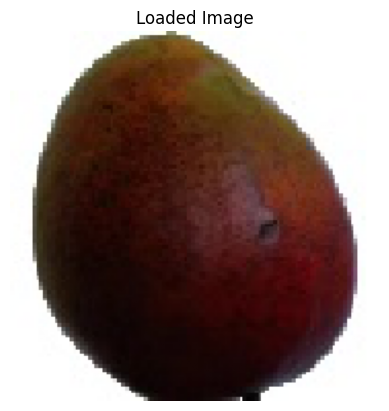

1/1 [==============================] - 1s 1s/step
Confidence:  100.0%
Class:  Mango


In [ ]:
predict_imgIV3('/content/drive/MyDrive/AI/Fruit Classification/Test/11_100.jpg')


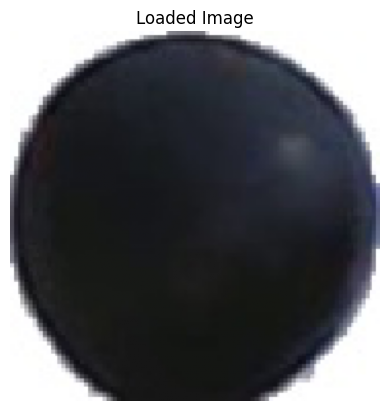

1/1 [==============================] - 0s 31ms/step
Confidence:  99.75%
Class:  Grape


In [ ]:
predict_imgIV3('/content/drive/MyDrive/AI/Fruit Classification/Test/14_100.jpg')

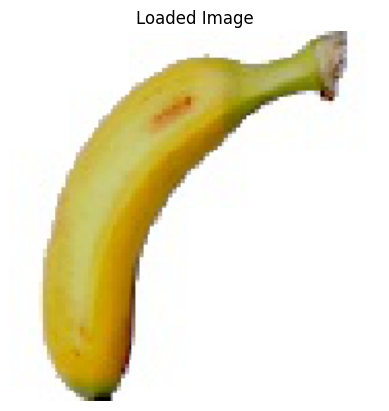

1/1 [==============================] - 0s 29ms/step
Confidence:  100.0%
Class:  Banana


In [ ]:
predict_imgIV3('/content/drive/MyDrive/AI/Fruit Classification/Test/1_100(2).jpg')

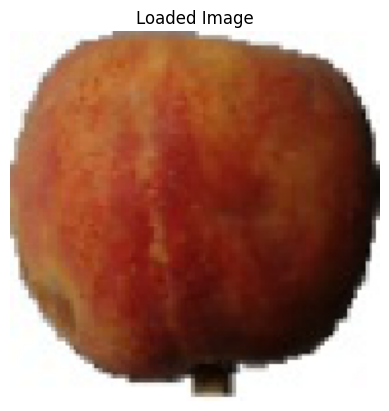

1/1 [==============================] - 0s 29ms/step
Confidence:  99.99%
Class:  Peach


In [ ]:
predict_imgIV3('/content/drive/MyDrive/AI/Fruit Classification/Test/26_100.jpg')

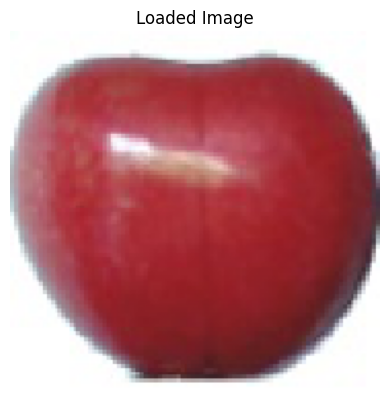

1/1 [==============================] - 0s 33ms/step
Confidence:  100.0%
Class:  Cherry


In [ ]:
predict_imgIV3('/content/drive/MyDrive/AI/Fruit Classification/Test/5_100.jpg')

Results

From achieving goood accuracy by doing CNN and Tranfer learning, we can assume that we can use fruit classifcation in real time.

